# Data Description
- Major League Baseball Data from the 1986 and 1987 seasons.
- There are 322 rows, with 59 rows of missing values. 263 left.
- The response variable is `Salary`, which is the 1987 annual salary in thousands of dollars.
- There are 20 variables:
    - AtBat: Number of times at bat in 1986
    - Hits: Number of hits in 1986
    - HmRun: Number of home runs in 1986
    - Runs: Number of runs in 1986
    - RBI: Number of runs batted in in 1986
    - Walks: Number of walks in 1986
    - Years: Number of years in the major leagues
    - CAtBat: Number of times at bat during his career
    - CHits: Number of hits during his career
    - CHmRun: Number of home runs during his career
    - CRuns: Number of runs during his career
    - CRBI: Number of runs batted in during his career
    - CWalks: Number of walks during his career
    - League: A factor with levels A and N indicating player’s league at the end of 1986
    - Division: A factor with levels E and W indicating player’s division at the end of 1986
    - PutOuts: Number of put outs in 1986
    - Assists: Number of assists in 1986
    - Errors: Number of errors in 1986
    - Salary: 1987 annual salary on opening day in thousands of dollars
    - NewLeague: A factor with levels A and N indicating player’s league at the beginning of 1987


# Load Packages and Data

In [21]:
import numpy as np, pandas as pd, matplotlib.pyplot as plt
import statsmodels.api as sm
import sklearn.model_selection as skm
import sklearn.linear_model as skl
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.cross_decomposition import PLSRegression
from sklearn.preprocessing import StandardScaler
from ISLP import load_data
from ISLP.models import \
     (ModelSpec as MS, Stepwise,
      sklearn_selected, sklearn_selection_path)
from functools import partial

In [22]:
Hitters = load_data('Hitters'); print(Hitters.shape); Hitters.head()

(322, 20)


,AtBat,Hits,HmRun,Runs,RBI,Walks,Years,CAtBat,CHits,CHmRun,CRuns,CRBI,CWalks,League,Division,PutOuts,Assists,Errors,Salary,NewLeague
0,293,66,1,30,29,14,1,293,66,1,30,29,14,A,E,446,33,20,NaN,A
1,315,81,7,24,38,39,14,3449,835,69,321,414,375,N,W,632,43,10,475.0,N
2,479,130,18,66,72,76,3,1624,457,63,224,266,263,A,W,880,82,14,480.0,A
3,496,141,20,65,78,37,11,5628,1575,225,828,838,354,N,E,200,11,3,500.0,N
4,321,87,10,39,42,30,2,396,101,12,48,46,33,N,E,805,40,4,91.5,N


In [23]:
Hitters.describe().round(1)

,AtBat,Hits,HmRun,Runs,RBI,Walks,Years,CAtBat,CHits,CHmRun,CRuns,CRBI,CWalks,PutOuts,Assists,Errors,Salary
count,322.0,322.0,322.0,322.0,322.0,322.0,322.0,322.0,322.0,322.0,322.0,322.0,322.0,322.0,322.0,322.0,263.0
mean,380.9,101.0,10.8,50.9,48.0,38.7,7.4,2648.7,717.6,69.5,358.8,330.1,260.2,288.9,106.9,8.0,535.9
std,153.4,46.5,8.7,26.0,26.2,21.6,4.9,2324.2,654.5,86.3,334.1,333.2,267.1,280.7,136.9,6.4,451.1
min,16.0,1.0,0.0,0.0,0.0,0.0,1.0,19.0,4.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,67.5
25%,255.2,64.0,4.0,30.2,28.0,22.0,4.0,816.8,209.0,14.0,100.2,88.8,67.2,109.2,7.0,3.0,190.0
50%,379.5,96.0,8.0,48.0,44.0,35.0,6.0,1928.0,508.0,37.5,247.0,220.5,170.5,212.0,39.5,6.0,425.0
75%,512.0,137.0,16.0,69.0,64.8,53.0,11.0,3924.2,1059.2,90.0,526.2,426.2,339.2,325.0,166.0,11.0,750.0
max,687.0,238.0,40.0,130.0,121.0,105.0,24.0,14053.0,4256.0,548.0,2165.0,1659.0,1566.0,1378.0,492.0,32.0,2460.0


In [24]:
np.isnan(Hitters['Salary']).sum()

59

In [25]:
Hitters = Hitters.dropna(); Hitters.shape

(263, 20)

In [40]:
# Create a data frame with the predictors
design = MS(Hitters.columns.drop('Salary'), intercept=False).fit(Hitters)
X = design.transform(Hitters)
# Define the response
Y = np.array(Hitters.Salary)

# Ridge Regression
## Ridge Regression for one $\lambda$
- We start with `X` (without an intercept)
- First, we standardize the columns of `X` to have mean 0 and standard deviation 1.
- There are two options to fit a ridge regression model:
    - `skl.Ridge()` from `sklearn.linear_model` with `alpha` as the penalty parameter.
    - `skl.ElasticNet()` from `sklearn.linear_model` with `l1_ratio=0` for ridge regression.
        - l1_ratio=0: Equivalent to ridge regression.
        - l1_ratio=1: Equivalent to lasso regression.
        - 0 < l1_ratio < 1: Hybrid model.
- The parameter $\lambda$ is called `alphas` in `sklearn`. For consistency, we refer to it as `lambdas`.

In [42]:
# Standardization 
Xs = X - X.mean(0)
# X.mean(0) is the mean of each column.
X_scale = X.std(0)
Xs = Xs / X_scale

- We create labmda values ranging from $\lambda=10^{8}$ to $\lambda=10^{-2}$ scaled by the standard deviation of y.
- This scaling is common and helps to make the regularization parameter more interpretable and ensures that it is on a comparable scale across different datasets.
    1. Normalization of Regularization Effect:
        - The regularization term in the loss function is added to RSS. If the scale of y is large, the RSS will be large, and the regularization term will have a relatively smaller effect. Conversely, if the scale of y is small, the RSS will be small, and the regularization term will have a relatively larger effect.
        - By scaling the regularization term by the standard deviation of y, we ensure that the regularization term has a consistent effect on the loss function, regardless of the scale of y.
    2. Comparability Across Datasets:
        - Different datasets can have different ranges and variances of y. Scaling $\lambda$ by the standard deviation of y makes it comparable across datasets, simplifying its choice and interpretation.
    3. Stability in Model Selection:
        - When performing model selection (e.g., cross-validation) to choose the best value of $\lambda$, scaling $\lambda$ by the standard deviation of y helps to stabilize the selection process. It ensures that the chosen value of $\lambda$ is not overly sensitive to the scale of y.

In [43]:
lambdas = 10**np.linspace(8, -2, 100) / Y.std()

In [44]:
# Fit Ridge regression with skl.ElasticNet
ridge_ElasticNet = skl.ElasticNet(alpha=lambdas[59], l1_ratio=0)
ridge_ElasticNet.fit(Xs, Y)
ridge_ElasticNet.coef_

/opt/conda/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.446e+07, tolerance: 5.332e+03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(


array([-13.3005187 ,  59.92118435,  -5.26938606,  29.71024579,
        22.07512716,  46.28613496, -11.41564922,  22.78731488,
        51.65310903,  43.29867592,  52.3943022 ,  54.59674491,
        -8.02429775,  17.75164816, -53.52337608,  62.57495417,
        10.38514852, -16.70723644,   0.58138502])

In [45]:
# Fit Ridge regression with skl.Ridge
ridge_Ridge = skl.Ridge(alpha=lambdas[59])
ridge_Ridge.fit(Xs, Y)
ridge_Ridge.coef_

array([-287.45819751,  326.17228564,   30.77458577,  -49.7055374 ,
        -20.48018016,  132.23989148,  -24.53253078, -337.5542032 ,
        112.77981245,    9.00178173,  421.09013528,  218.75757384,
       -204.4036048 ,   31.32393437,  -59.15218623,   78.91948687,
         51.99330477,  -22.79221502,  -12.98903184])

In [46]:
# Fit Ridge regression with skl.ridge_regression
skl.ridge_regression(Xs, Y, alpha=lambdas[59])

array([-287.45819751,  326.17228564,   30.77458577,  -49.7055374 ,
        -20.48018016,  132.23989148,  -24.53253078, -337.5542032 ,
        112.77981245,    9.00178173,  421.09013528,  218.75757384,
       -204.4036048 ,   31.32393437,  -59.15218623,   78.91948687,
         51.99330477,  -22.79221502,  -12.98903184])

## Ridge Regression for Multiple $\lambda$

In [47]:
# Ignore UserWarning
import warnings
warnings.filterwarnings('ignore', category=UserWarning)

- By default, `ElasticNet.path` automatically selects a range of $\lambda$ values. This range is chosen to cover the entire path from the maximum $\lambda$ value, where all coefficients are zero, to the minimum $\lambda$ value, where the regularization effect is minimal.
- For models with L1 regularization (Lasso or ElasticNet with l1_ratio > 0), there exists a smallest $\lambda$ value for which all coefficients become zero. This value can be computed and used as the starting point for the path.
- When l1_ratio=0, the ElasticNet model reduces to Ridge regression, which uses only L2 regularization.
- For Ridge regression, there is no finite $\lambda$ value for which all coefficients become zero. Theoretically, the smallest $\lambda$ value for which all coefficients are zero is $\infty$. This is because L2 regularization shrinks coefficients towards zero but never exactly to zero unless $\lambda=\infty$.

In [48]:
# Fit 100 Ridge regressions with skl.ElasticNet.path
soln_array = skl.ElasticNet.path(Xs, Y, l1_ratio=0., alphas=lambdas)[1]
print(soln_array.shape)
# row is coefficient, column is lambda
# Show the coefficients of the second lambda
soln_array[:,1]

(19, 100)


array([ 1.00794710e-03,  1.12004920e-03,  8.75830928e-04,  1.07200463e-03,
        1.14757428e-03,  1.13330644e-03,  1.02296897e-03,  1.34334911e-03,
        1.40149947e-03,  1.34027451e-03,  1.43665292e-03,  1.44760124e-03,
        1.25063102e-03, -3.64581620e-05, -4.91549097e-04,  7.67212991e-04,
        6.49455848e-05, -1.37907459e-05, -7.23154900e-06])

In [50]:
# Show the coefficients of all 100 lambdas
soln_path = pd.DataFrame(soln_array.T,
                         columns=X.columns,
                         index=-np.log(lambdas))
soln_path.index.name = 'negative log(lambda)'
soln_path.round(3)

,AtBat,Hits,HmRun,Runs,RBI,Walks,Years,CAtBat,CHits,CHmRun,CRuns,CRBI,CWalks,League[N],Division[W],PutOuts,Assists,Errors,NewLeague[N]
negative log(lambda),,,,,,,,,,,,,,,,,,,
-12.310855,0.001,0.001,0.001,0.001,0.001,0.001,0.001,0.001,0.001,0.001,0.001,0.001,0.001,-0.000,-0.000,0.001,0.000,-0.000,-0.000
-12.078271,0.001,0.001,0.001,0.001,0.001,0.001,0.001,0.001,0.001,0.001,0.001,0.001,0.001,-0.000,-0.000,0.001,0.000,-0.000,-0.000
-11.845686,0.001,0.001,0.001,0.001,0.001,0.001,0.001,0.002,0.002,0.002,0.002,0.002,0.002,-0.000,-0.001,0.001,0.000,-0.000,-0.000
-11.613102,0.002,0.002,0.001,0.002,0.002,0.002,0.002,0.002,0.002,0.002,0.002,0.002,0.002,-0.000,-0.001,0.001,0.000,-0.000,-0.000
-11.380518,0.002,0.002,0.002,0.002,0.002,0.002,0.002,0.003,0.003,0.003,0.003,0.003,0.003,-0.000,-0.001,0.002,0.000,-0.000,-0.000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9.784658,-291.377,337.569,37.392,-59.859,-26.556,135.112,-17.251,-388.503,89.755,-12.290,476.969,257.749,-213.528,31.318,-58.569,78.911,53.724,-22.251,-12.427
10.017243,-291.433,337.754,37.501,-60.029,-26.656,135.157,-17.142,-389.189,89.179,-12.680,477.927,258.448,-213.685,31.316,-58.560,78.911,53.747,-22.241,-12.416
10.249827,-291.477,337.901,37.588,-60.164,-26.736,135.193,-17.056,-389.731,88.713,-12.992,478.692,259.008,-213.811,31.315,-58.553,78.911,53.765,-22.233,-12.407


- We plot the coefficients against the log of $\lambda$ values.
- We set `legend` to `False` in the plot method, then add the legend later using `ax.legend()` to control its position.

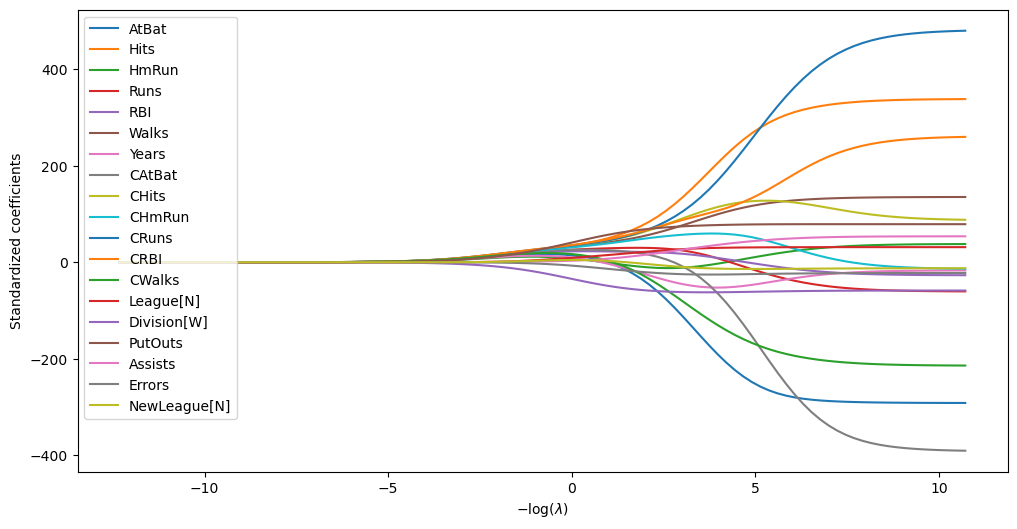

In [51]:
path_fig, ax = plt.subplots(figsize=(12,6))
soln_path.plot(ax=ax, legend=False)
# columns must be coefficient and row must be negative log(lambda)
ax.set_xlabel(r'$-\log(\lambda)$'); ax.set_ylabel('Standardized coefficients')
ax.legend(loc='upper left');

- The $\ell_2$ norm is the square root of the sum of squared coefficients.
- When $\lambda$ is large, the coefficients are smaller in $\ell_2$ norm, and vice versa.
- Here, we show the coefficients at the 40th step, where $\lambda$ is 25.535.

In [52]:
beta_hat = soln_path.iloc[39]
lambdas[39], np.linalg.norm(beta_hat)

(25.53538897200662, 24.144360989242685)

- In contrast, here’s the $\ell_2$ norm when $\lambda$ is 0.244.

In [53]:
beta_hat = soln_path.loc[soln_path.index[59]]
lambdas[59], np.linalg.norm(beta_hat)

(0.24374766133488554, 160.54036295923294)

- We can use the Pipeline object in `sklearn` to combine the normalization and ridge regression steps.
- Notice that the `pipe.fit(X, Y)` operation updated the `ridge` object, adding attributes like `coef_` that weren’t there before.

In [54]:
ridge = skl.ElasticNet(alpha=lambdas[59], l1_ratio=0)
scaler = StandardScaler(with_mean=True,  with_std=True)
pipe = Pipeline(steps=[('scaler', scaler), ('ridge', ridge)])
pipe.fit(X, Y)
np.linalg.norm(ridge.coef_)

160.42371017725895

In [55]:
# Fit 100 Ridge regressions with skl.RidgeCV
ridge_CV = skl.RidgeCV(alphas=lambdas, store_cv_results = True)
ridge_CV.fit(Xs, Y)
# The coefficients of the best model
ridge_CV.coef_

array([-222.38068208,  238.30701854,    3.03160338,   -2.59826705,
          3.81569529,  108.86093917,  -51.00301739, -104.04140321,
        122.06154203,   57.40242319,  209.46975086,  117.90668903,
       -149.96262446,   30.41109664,  -61.75647225,   77.86857001,
         40.038001  ,  -25.08282625,  -13.69993768])

## Estimating Validation Error of Ridge Regression
- We split the data into training (50%) and validation set (50%).
- We use the training set to fit the ridge regression model for a lambda = 0.01
- We calculate the MSE on the validation set.

In [56]:
# Split the data into the training and validation set
validation = skm.ShuffleSplit(n_splits=1, test_size=0.5, random_state=0)
# Set the Ridge regression
ridge = skl.ElasticNet(alpha=0.01, l1_ratio=0)
# Fit the model on the training set
results = skm.cross_validate(ridge, X, Y, scoring='neg_mean_squared_error',
                             cv=validation)
# Show the MSE of the validation set
-results['test_score']

array([134214.00419204])

In [57]:
# We can use skm.Ridge instead of skm.ElasticNet
ridge = skl.Ridge(alpha=0.01)
results = skm.cross_validate(ridge, X, Y, scoring='neg_mean_squared_error',
                             cv=validation)
-results['test_score']

array([134596.76230062])

- We calculate MSE for $\lambda = 10^{10}$.
- In this case, all coefficients are almost zero. This is equivalent to the null model, which predicts the mean of the response for all observations.

In [58]:
ridge = skl.ElasticNet(alpha=1e10, l1_ratio=0)
results = skm.cross_validate(ridge, X, Y, scoring='neg_mean_squared_error',
                             cv=validation)
-results['test_score']

array([231788.32155285])

## Use Validation Set to Select $\lambda$
- We use `GridSearchCV()` of `sklearn.model_selection` to search for the best $\lambda$.

In [59]:
# Create a dictionary of lambdas
param_grid = {'ridge__alpha': lambdas}
# Create a pipeline
ridge = skl.ElasticNet(l1_ratio=0)
scaler = StandardScaler(with_mean=True,  with_std=True)
pipe = Pipeline(steps=[('scaler', scaler), ('ridge', ridge)])
# Set the grid search
grid = skm.GridSearchCV(pipe, param_grid, cv=validation,
                        scoring='neg_mean_squared_error')
# Fit the grid search
grid.fit(X, Y);

In [60]:
# Show the best lambda
print(grid.best_params_)
# Get the corresponding estimator
best_model = grid.best_estimator_
# Show the coefficients of the best model
best_model.named_steps['ridge'].coef_

{'ridge__alpha': 0.005899006046740856}


array([-257.25384692,  278.75378725,   12.65425786,  -19.89449632,
         -4.44329499,  119.7460362 ,  -44.11291512, -178.08337253,
        127.25970252,   48.00333019,  278.29934481,  141.6104627 ,
       -173.70460313,   30.84178877,  -60.78443234,   78.39929602,
         45.04343139,  -24.2382454 ,  -13.8265259 ])

## Use cross-validation to select $\lambda$

In [61]:
# Create k-fold cross-validation
kfold = skm.KFold(n_splits=5, shuffle=True, random_state=0)
# Create a dictionary of lambdas
param_grid = {'ridge__alpha': lambdas}
# Create a pipeline
ridge = skl.ElasticNet(l1_ratio=0)
scaler = StandardScaler(with_mean=True,  with_std=True)
pipe = Pipeline(steps=[('scaler', scaler), ('ridge', ridge)])
# Set the grid search
grid = skm.GridSearchCV(pipe, param_grid, cv=kfold,
                        scoring='neg_mean_squared_error')
# Fit the grid search
grid.fit(X, Y);

In [62]:
# Show the best lambda
print(grid.best_params_)
# Get the corresponding estimator
best_model = grid.best_estimator_
# Show the coefficients of the best model
best_model.named_steps['ridge'].coef_

{'ridge__alpha': 0.01185247763144249}


array([-222.80877051,  238.77246614,    3.21103754,   -2.93050845,
          3.64888723,  108.90953869,  -50.81896152, -105.15731984,
        122.00714801,   57.1859509 ,  210.35170348,  118.05683748,
       -150.21959435,   30.36634231,  -61.62459095,   77.73832472,
         40.07350744,  -25.02151514,  -13.68429544])

- We plot the cross-validated MSE as a function of $-\log(\lambda)$, which has shrinkage decreasing from left to right.

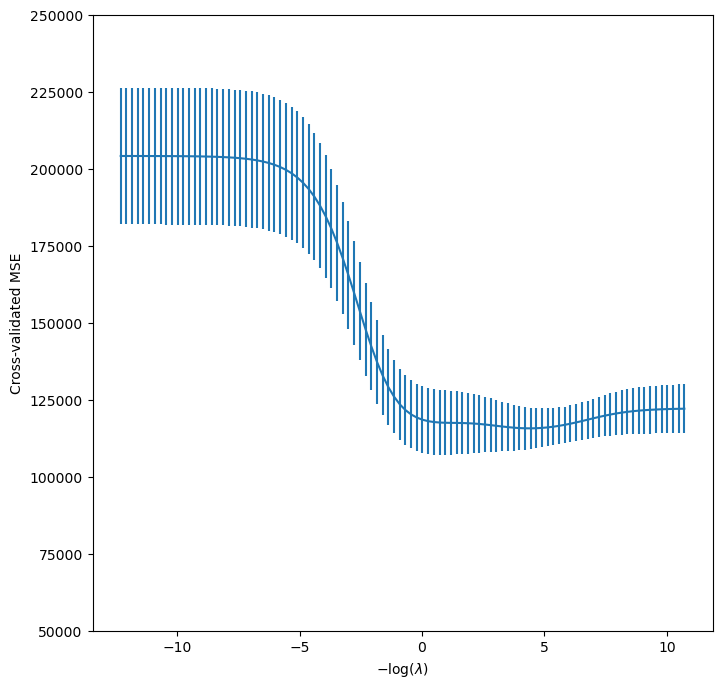

In [47]:
ridge_fig, ax = plt.subplots(figsize=(8,8))
ax.errorbar(x=-np.log(lambdas), y=-grid.cv_results_['mean_test_score'],
            yerr=grid.cv_results_['std_test_score'] / np.sqrt(K))
# grid.cv_results_['mean_test_score'] are the mean of five negative MSEs for each lambda
# grid.cv_results_['std_test_score'] are standard deviations of the mean
ax.set_ylim([50000,250000])
ax.set_xlabel(r'$-\log(\lambda)$'); ax.set_ylabel('Cross-validated MSE');

- We can use `GridSearchCV()` to search for the best $\lambda$ with $R^2$ as the scoring criterion.
- The criterion of $R^2$ is the default in `GridSearchCV()`.
- Then we plot the cross-validated $R^2$ against $-\log(\lambda)$.

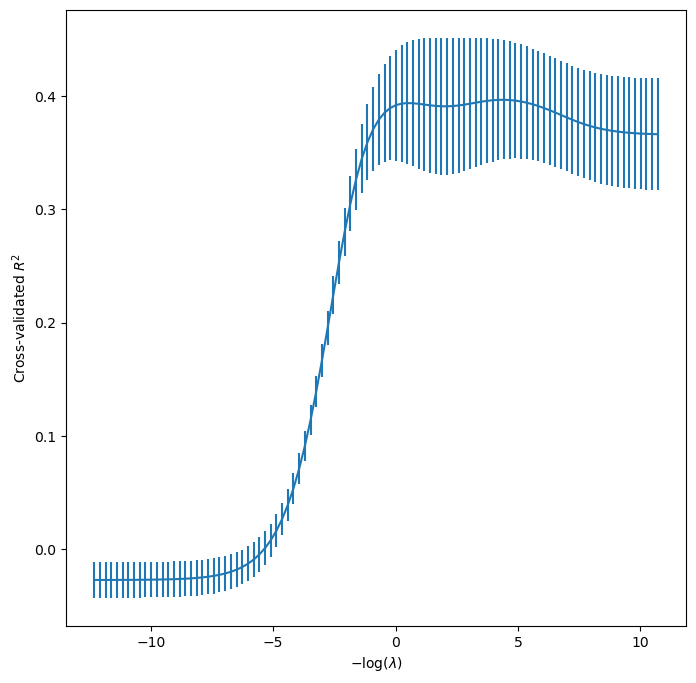

In [48]:
# Set and fit the grid search with R² as scoring criterion
grid_r2 = skm.GridSearchCV(pipe, param_grid, cv=kfold)
grid_r2.fit(X, Y)
# Set axis for the figure
r2_fig, ax = plt.subplots(figsize=(8,8))
# Draw the figure
ax.errorbar(-np.log(lambdas),
            grid_r2.cv_results_['mean_test_score'],
            yerr=grid_r2.cv_results_['std_test_score'] / np.sqrt(K))
ax.set_xlabel(r'$-\log(\lambda)$'); ax.set_ylabel('Cross-validated $R^2$');

## Fast Cross-Validation for Solution Paths
- Ridge, lasso, and elastic net has a version `CV` that can be used to fit a series of $\lambda$ values.
- There is a difference in the results between `grid` and `pipeCV` because of the standardization.
- In `GridSearchCV`: mean and standard deviation are calculated in the training set of each fold. These standardization parameters are then used to standardize the training and validation sets.
- In `CV`: mean and standard deviation are calculated the entire dataset. These standardization parameters are then used to standardize the training and validation sets.
- `GridSearchCV` ensures no data leakage, but `CV` is faster. Data leakage, also known as information leakage, occurs when information from outside the training dataset is used to create the model.
- If the dataset is large and the distribution of features is stable across folds, the impact of this difference might be minimal. The mean and standard deviation computed from the entire dataset will be similar to those computed from the training data of each fold.

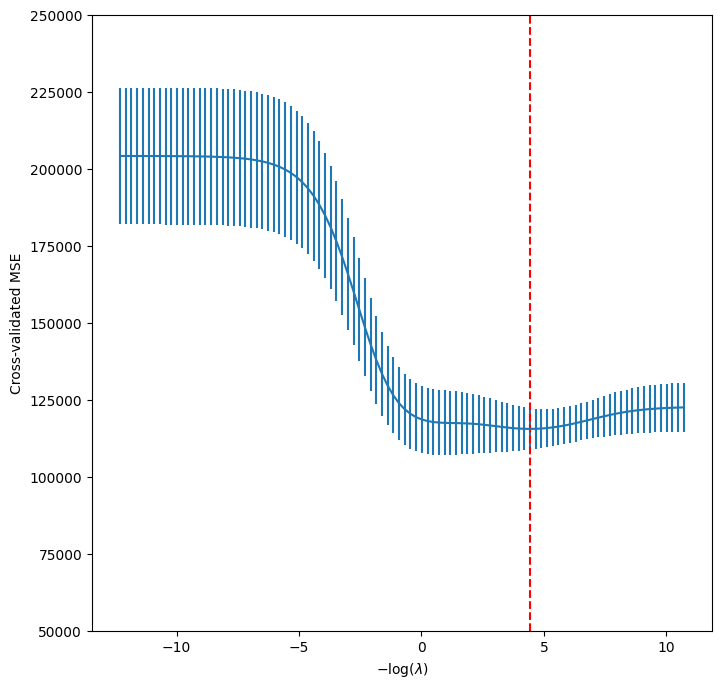

In [47]:
# Set rigdeCV
ridgeCV = skl.ElasticNetCV(alphas=lambdas, l1_ratio=0, cv=kfold)
# Set pipeline and fit
pipeCV = Pipeline(steps=[('scaler', scaler), ('ridge', ridgeCV)])
pipeCV.fit(X, Y)
# Extract `ElasticNetCV` from the pipeline
tuned_ridge = pipeCV.named_steps['ridge']
# Set the figure
ridgeCV_fig, ax = plt.subplots(figsize=(8,8))
# Draw the figure
ax.errorbar(-np.log(lambdas),
            tuned_ridge.mse_path_.mean(1), # mean of five MSEs for each lambda
            yerr=tuned_ridge.mse_path_.std(1) / np.sqrt(K)) # standard deviation of the mean
ax.axvline(-np.log(tuned_ridge.alpha_), c='r', ls='--') # vertical line at the best lambda
ax.set_ylim([50000,250000])
ax.set_xlabel(r'$-\log(\lambda)$'); ax.set_ylabel('Cross-validated MSE');

- To be clear, we show the best $\lambda$ and the test MSE associated with this $\lambda$.

In [48]:
print('Best lambda:', tuned_ridge.alpha_.round(3))
print('Best -log(lambda):', -np.log(tuned_ridge.alpha_).round(3))
print('Test MSE:', tuned_ridge.mse_path_.mean(1)[59].round(3))

Best lambda: 0.012
Best -log(lambda): 4.435
Test MSE: 117408.574


- We show the coefficients of the model with the best $\lambda$.

In [49]:
tuned_ridge.coef_

array([-222.80877051,  238.77246614,    3.21103754,   -2.93050845,
          3.64888723,  108.90953869,  -50.81896152, -105.15731984,
        122.00714801,   57.1859509 ,  210.35170348,  118.05683748,
       -150.21959435,   30.36634231,  -61.62459095,   77.73832472,
         40.07350744,  -25.02151514,  -13.68429544])

- As expected, none of the coefficients are zero — ridge regression does not perform variable selection!

## Evaluating Test Error of Cross-Validated Ridge
- We apply a mixed approach of cross-validation and validation set.
- We split the data into training (75%) and test set (25%). We tune ridge regression on the training set using 5-fold cross-validation, then evaluate it on the test set.

In [50]:
outer_valid = skm.ShuffleSplit(n_splits=1, 
                               test_size=0.25,
                               random_state=1)
inner_cv = skm.KFold(n_splits=5,
                     shuffle=True,
                     random_state=2)
ridgeCV = skl.ElasticNetCV(alphas=lambdas,
                           l1_ratio=0,
                           cv=inner_cv)
pipeCV = Pipeline(steps=[('scaler', scaler),
                         ('ridge', ridgeCV)])
results = skm.cross_validate(pipeCV, X, Y, cv=outer_valid,
                             scoring='neg_mean_squared_error')
-results['test_score']

array([132393.84003227])

# The Lasso

In [51]:
# Use skl.ElasticNetCV() with l1_ratio=1
lassoCV = skl.ElasticNetCV(n_alphas=100,
                           l1_ratio=1,
                           cv=kfold)
pipeCV = Pipeline(steps=[('scaler', scaler),
                         ('lasso', lassoCV)])
pipeCV.fit(X, Y)
tuned_lasso = pipeCV.named_steps['lasso']
tuned_lasso.alpha_

3.1472370031649866

In [52]:
# Use skl.LassoCV
lassoCV2 = skl.LassoCV(n_alphas=100,
                      cv=kfold)
pipeCV2 = Pipeline(steps=[('scaler', scaler),
                          ('lasso', lassoCV2)])
pipeCV2.fit(X, Y)
tuned_lasso2 = pipeCV2.named_steps['lasso']
tuned_lasso2.alpha_

3.1472370031649866

In [53]:
# Use skl.ElasticNet.path() with l1_ratio=1
soln_array = skl.ElasticNet.path(Xs, Y, l1_ratio=1, n_alphas=100)[1]
soln_path = pd.DataFrame(soln_array.T,
                         columns=D.columns,
                         index=-np.log(lambdas))
soln_path

,AtBat,Hits,HmRun,Runs,RBI,Walks,Years,CAtBat,CHits,CHmRun,CRuns,CRBI,CWalks,League[N],Division[W],PutOuts,Assists,Errors,NewLeague[N]
-12.310855,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,-0.000000,-0.000000,0.000000,0.000000,-0.000000,-0.000000
-12.078271,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,17.205159,0.000000,-0.000000,-0.000000,0.000000,0.000000,-0.000000,-0.000000
-11.845686,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,33.250748,0.000000,-0.000000,-0.000000,0.000000,0.000000,0.000000,-0.000000
-11.613102,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,6.545671,42.024827,0.000000,-0.000000,-0.000000,0.000000,0.000000,0.000000,0.000000
-11.380518,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,13.727251,49.189007,0.000000,-0.000000,-0.000000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9.784658,-292.618320,330.147359,25.671504,-49.562410,-13.598973,130.583914,-24.123416,-286.579896,31.226178,-0.0,452.829429,229.229316,-209.493673,28.373513,-58.125944,79.096546,49.338699,-20.820927,-9.515995
10.017243,-292.511837,330.496934,26.317012,-50.124459,-14.357879,130.849065,-23.603337,-294.116322,37.120221,-0.0,453.537777,229.848245,-209.616048,28.584855,-58.145706,79.080585,49.655372,-20.923792,-9.725398
10.249827,-292.413043,330.823484,26.918970,-50.648775,-15.065567,131.096456,-23.118630,-301.141293,42.613785,-0.0,454.198913,230.425310,-209.730604,28.781925,-58.164143,79.065724,49.950637,-21.019700,-9.920665
10.482412,-292.320279,331.127368,27.480414,-51.137572,-15.725645,131.327039,-22.666199,-307.697118,47.741074,-0.0,454.814838,230.963666,-209.836915,28.965748,-58.181330,79.051835,50.226081,-21.109174,-10.102799


In [54]:
# Use skl.Lasso.path()
lambdas, soln_array = skl.Lasso.path(Xs, Y, l1_ratio=1, n_alphas=100)[:2]
soln_path = pd.DataFrame(soln_array.T,
                         columns=D.columns,
                         index=-np.log(lambdas))
soln_path

,AtBat,Hits,HmRun,Runs,RBI,Walks,Years,CAtBat,CHits,CHmRun,CRuns,CRBI,CWalks,League[N],Division[W],PutOuts,Assists,Errors,NewLeague[N]
-5.542369,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,-0.000000,-0.000000,0.000000,0.000000,-0.000000,-0.000000
-5.472594,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,17.205159,0.000000,-0.000000,-0.000000,0.000000,0.000000,-0.000000,-0.000000
-5.402819,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,33.250748,0.000000,-0.000000,-0.000000,0.000000,0.000000,0.000000,-0.000000
-5.333043,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,6.545671,42.024827,0.000000,-0.000000,-0.000000,0.000000,0.000000,0.000000,0.000000
-5.263268,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,13.727251,49.189007,0.000000,-0.000000,-0.000000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1.086285,-292.618320,330.147359,25.671504,-49.562410,-13.598973,130.583914,-24.123416,-286.579896,31.226178,-0.0,452.829429,229.229316,-209.493673,28.373513,-58.125944,79.096546,49.338699,-20.820927,-9.515995
1.156060,-292.511837,330.496934,26.317012,-50.124459,-14.357879,130.849065,-23.603337,-294.116322,37.120221,-0.0,453.537777,229.848245,-209.616048,28.584855,-58.145706,79.080585,49.655372,-20.923792,-9.725398
1.225835,-292.413043,330.823484,26.918970,-50.648775,-15.065567,131.096456,-23.118630,-301.141293,42.613785,-0.0,454.198913,230.425310,-209.730604,28.781925,-58.164143,79.065724,49.950637,-21.019700,-9.920665
1.295611,-292.320279,331.127368,27.480414,-51.137572,-15.725645,131.327039,-22.666199,-307.697118,47.741074,-0.0,454.814838,230.963666,-209.836915,28.965748,-58.181330,79.051835,50.226081,-21.109174,-10.102799


We can see from the coefficient plot of the standardized coefficients that depending on the choice of
tuning parameter, some of the coefficients will be exactly equal to
zero.

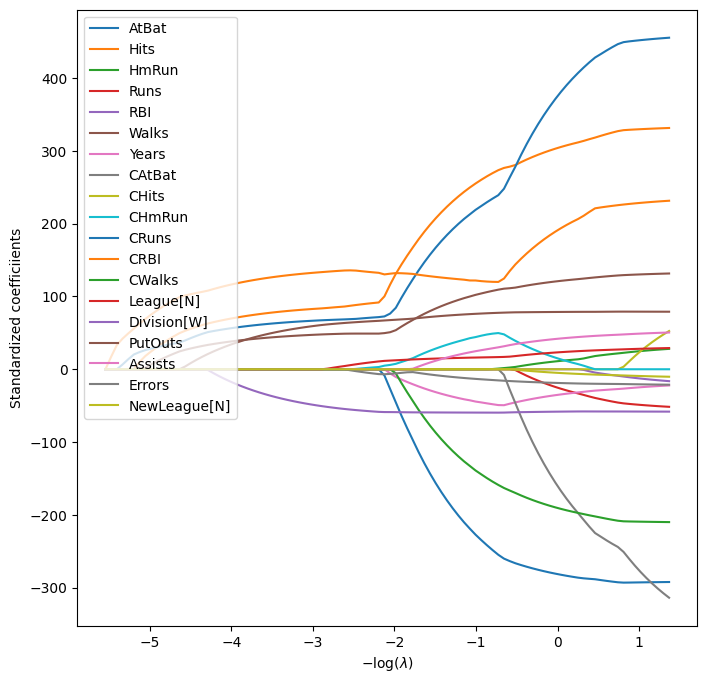

In [55]:
path_fig, ax = plt.subplots(figsize=(8,8))
soln_path.plot(ax=ax, legend=False)
ax.legend(loc='upper left')
ax.set_xlabel(r'$-\log(\lambda)$'); ax.set_ylabel('Standardized coefficiients');

- We show the best $\lambda$ and the test MSE associated with this $\lambda$.
- The best $\lambda$ and the test MSE of the Ridge model are 0.012 and 117408.574, respectively.

In [56]:
print('Best lambda:', tuned_lasso.alpha_.round(3))
print('Best -log(lambda):', -np.log(tuned_lasso.alpha_).round(3))
print('Test MSE:', tuned_lasso.mse_path_.mean(1)[59].round(3))

Best lambda: 3.147
Best -log(lambda): -1.147
Test MSE: 115411.106


- We plot of the cross-validation error.


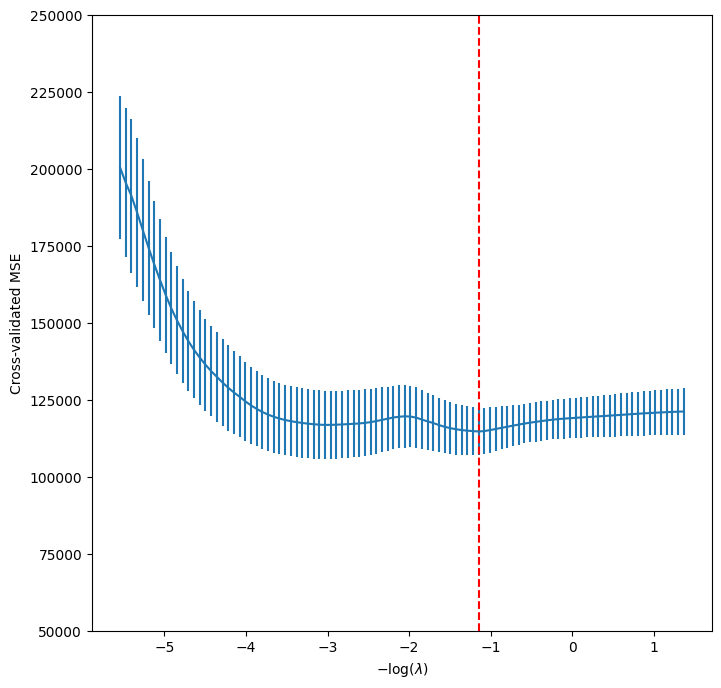

In [57]:
lassoCV_fig, ax = plt.subplots(figsize=(8,8))
ax.errorbar(-np.log(tuned_lasso.alphas_),
            tuned_lasso.mse_path_.mean(1),
            yerr=tuned_lasso.mse_path_.std(1) / np.sqrt(K))
ax.axvline(-np.log(tuned_lasso.alpha_), c='r', ls='--')
ax.set_ylim([50000,250000])
ax.set_xlabel(r'$-\log(\lambda)$'); ax.set_ylabel('Cross-validated MSE');

- We show the coefficients of the model with the best $\lambda$.
- The lasso's hat 6 of the 19 coefficients are exactly zero, so the lasso model includes only 13 variables.

In [58]:
tuned_lasso.coef_

array([-210.01008773,  243.4550306 ,    0.        ,    0.        ,
          0.        ,   97.69397357,  -41.52283116,   -0.        ,
          0.        ,   39.62298193,  205.75273856,  124.55456561,
       -126.29986768,   15.70262427,  -59.50157967,   75.24590036,
         21.62698014,  -12.04423675,   -0.        ])

- Like ridge regression, evaluate cross-validated lasso's test error by splitting into test and training sets, then running cross-validation on the training set and evaluating on the test set.

# Principal Components Regression

- We use `PCA()` from `sklearn.decomposition` to perform Principal Components Regression (PCR) on the `Hitters` data to predict `Salary`.
- We use `LinearRegression()` to fit the regression model, which includes an intercept by default, unlike `OLS()` from earlier.

In [68]:
pca = PCA(n_components=2)
linreg = skl.LinearRegression()
pipe = Pipeline([('pca', pca), ('linreg', linreg)])
pipe.fit(X, Y)
pipe.named_steps['linreg'].coef_

array([0.09846131, 0.4758765 ])

- We add a standardization step to the pipeline and refit the model.

In [69]:
pipe = Pipeline([('scaler', scaler),('pca', pca),('linreg', linreg)])
pipe.fit(X, Y)
pipe.named_steps['linreg'].coef_

array([106.36859204,  21.60350456])

- We use `GridSearchCV()` to select the number of components by varying the `n_components` parameter.

In [70]:
# Create a dictionary of n_components
param_grid = {'pca__n_components': range(1, 20)}
# Create a pipeline
pca = PCA(n_components=2)
linreg = skl.LinearRegression()
pipe_grid = Pipeline([('pca', pca),('linreg', linreg)])
# Create and fit the grid search
grid_pca = skm.GridSearchCV(pipe_grid, param_grid, cv=kfold,
                        scoring='neg_mean_squared_error')
grid_pca.fit(X, Y);

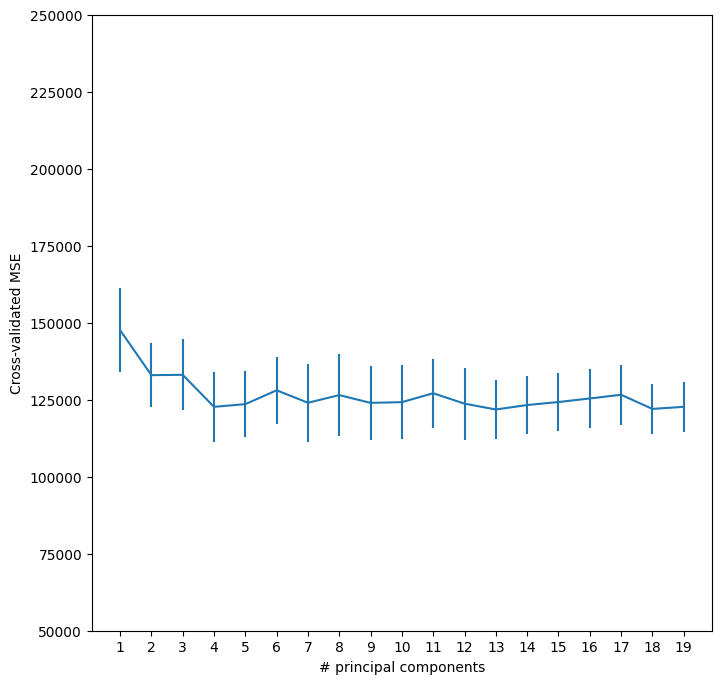

In [71]:
# Set the figure
pcr_fig, ax = plt.subplots(figsize=(8,8))
# Set number of principal components
n_comp = param_grid['pca__n_components'] # from 1 to 19
# Draw the figure
ax.errorbar(n_comp,
            -grid_pca.cv_results_['mean_test_score'],
            grid_pca.cv_results_['std_test_score'] / np.sqrt(K))
ax.set_ylabel('Cross-validated MSE')
ax.set_xlabel('# principal components')
ax.set_xticks(n_comp); ax.set_ylim([50000,250000]);

- 13 components provide the smallest cross-validation error, but 4 component provide similar cross-validation error. We should choose the model with fewer components.
- We show the cross-validated MSE for the best number of components.

In [72]:
# Retrieve the best cross-validation score (negative MSE)
print("Best test MSE:", -grid_pca.best_score_)
print("Test MSE of 4 components:", -grid_pca.cv_results_['mean_test_score'][3])

Best test MSE: 121830.86740098316
Test MSE of 4 components: 122692.82329896805


In [73]:
# Retrieve the best estimator
best_pca = grid_pca.best_estimator_
# Retrieve the best number of components
best_n_components = grid_pca.best_params_['pca__n_components']
# Retrieve the coefficients of the linear regression model within the best estimator
best_coefs = best_pca.named_steps['linreg'].coef_
print("Best number of components:", best_n_components)
print("Coefficients of the best model:", best_coefs)

Best number of components: 13
Coefficients of the best model: [ 9.84613138e-02  4.75876498e-01  2.61402132e-01  8.06219481e-01
 -1.15459449e-01  1.33865933e-01  1.45027199e+00 -2.98855499e-03
  4.04929806e+00  3.13327986e+00  1.29026346e+00  4.71933057e+00
 -7.10388951e+00]


- We use `explained_variance_ratio_` attribute to show the percentage of variance explained by each component.
- In this case, we use only two components.

In [74]:
pipe.named_steps['pca'].explained_variance_ratio_

array([0.3831424 , 0.21841076])

- `PCA()` from `sklearn.decomposition` does not allow fitting an intercept with `n_components=0`, so we also compute the MSE for the null model by ourself.

In [75]:
# Create a column of 263 zeros
Xn = np.zeros((X.shape[0], 1))
# Fit the null model
linreg = skl.LinearRegression()
cv_null = skm.cross_validate(linreg, Xn, Y, cv=kfold,
                             scoring='neg_mean_squared_error')
# Show the test MSE
-cv_null['test_score'].mean()

204139.30692994667

- With \(M=1\), we capture 38.31% of the variance.
- With \(M=2\), we capture an additional 21.84%, totaling 60.15%.
- By \(M=6\), this increases to 88.63%.
- Beyond that, the increments diminish until we use all \(M=p=19\) components, which capture 100% of the variance.

# Partial Least Squares
- We use `PLSRegression()` from `sklearn.cross_decomposition` to perform Partial Least Squares (PLS) on the `Hitters` data to predict `Salary`.
- The n_components parameter in PLSRegression specifies the number of latent variables (components) to extract from the predictors
- However, the number of coefficients corresponds to the number of features in the input data X, not the number of components.

In [76]:
pls = PLSRegression(n_components=2, scale=True)
pls.fit(X, Y)
pls.coef_

array([[ 1.83212805e-01,  9.68182742e-01,  1.43446217e+00,
         1.41606603e+00,  1.19172425e+00,  1.95842670e+00,
         1.86868624e+00,  1.15591692e-02,  5.21901102e-02,
         3.68371731e-01,  1.04817110e-01,  1.08841878e-01,
         7.60605534e-02,  3.59616391e+01, -9.59000208e+01,
         2.01055281e-01,  2.89459285e-02, -6.55086150e-01,
         3.02144105e+01]])

- Similar to PCR, we will use cross-validation (CV) to determine the optimal number of components.

In [77]:
# Create a dictionary of n_components
param_grid = {'n_components':range(1, 20)}
# Set and fit the grid search
pls = PLSRegression(n_components=2, scale=True)
grid_pls = skm.GridSearchCV(pls, param_grid, cv=kfold,
                        scoring='neg_mean_squared_error')
grid_pls.fit(X, Y);

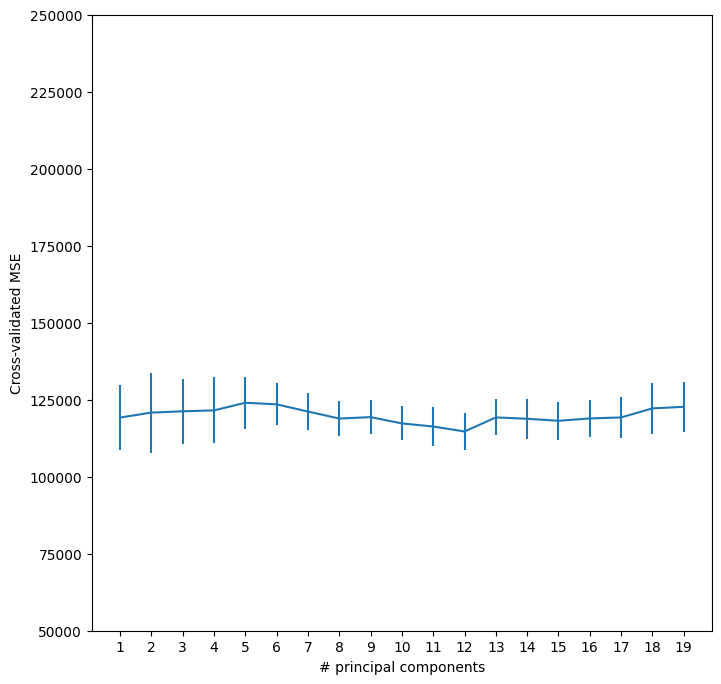

In [78]:
# Set the figure
pls_fig, ax = plt.subplots(figsize=(8,8))
n_comp = param_grid['n_components']
ax.errorbar(n_comp, # from 1 to 19
            -grid_pls.cv_results_['mean_test_score'],
            grid_pls.cv_results_['std_test_score'] / np.sqrt(K))
ax.set_ylabel('Cross-validated MSE')
ax.set_xlabel('# principal components')
ax.set_xticks(n_comp); ax.set_ylim([50000,250000]);

- The CV error is minimized at 12 components, but there is only a small difference in performance compared to using just 2 or 3 components.
- We show the cross-validated MSE. The best cross-validated MSE of PCA is 121830.867.

In [79]:
# Retrieve the best cross-validation score (negative MSE)
print("Best test MSE:", -grid_pls.best_score_)

Best test MSE: 114684.61271597291


In [80]:
# Retrieve the best estimator
best_pls = grid_pls.best_estimator_
# Show the coefficients of the best model
best_pls.coef_

array([[-2.32992558e+00,  8.26335294e+00,  2.89679183e+00,
        -1.19106620e+00, -1.11285475e+00,  6.24444457e+00,
        -9.47365759e+00, -6.85457537e-02,  2.24296795e-01,
         9.67344689e-01,  7.81606471e-01,  3.60963108e-01,
        -7.41734162e-01,  4.77892567e+01, -1.21742412e+02,
         2.82834400e-01,  3.15542697e-01, -2.62713059e+00,
        -1.51324511e+01]])